In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, metrics, ensemble
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
import xgboost as xg
import pandas as pd
import stop_words
import itertools
import textblob
import string
import numpy
import os

## Загрузка и обработка датасета:
* Загрузка датасета
* Очистка текстов от тэгов "### tag ###"
* Очитска текстов от чисел, знаков препринания и стоп-слов + лемматизация
* Преобразование датасета к виду ['МЕТКА', 'текст']

In [2]:
def open_data_set(dataset_path):
    try:
        dataset = [open(os.path.join(dataset_path, filename), 'r').read()
                   for filename in os.listdir(dataset_path)
                   if filename.endswith(".txt")]
        return dataset
    except Exception as e:
        print(e)
    raise SystemExit

In [3]:
def clear_tags(dataset, tag):
    if dataset:
        output = []
        for text_ in dataset:
            while tag in text_:
                ind1 = text_.find(tag)
                ind2 = text_[ind1 + len(tag):].find(tag) + len(tag) * 2 + ind1
                text_ = text_[:ind1] + text_[ind2 + 1:]
            output.append(text_.replace("\t", ' ').
                          replace("--", ' ').
                          replace("  ", ' '))
        return output       #  ['text1', 'text2'...]
    else:
        print("No dataset")

In [4]:
def remove_noise(input_text):
    table = str.maketrans("", "", string.punctuation + "1234567890")
    punct_free_text = input_text.translate(table)
    noise_list = stop_words.get_stop_words("en") + ["et", "al", "eg", "le"]
    words = punct_free_text.split()
    noise_free_words = [textblob.Word(word).lemmatize() for word in words if word not in noise_list]
    noise_free_text = " ".join(noise_free_words)
    return noise_free_text.strip()

In [5]:
def generate_dataset(dataset):
    if dataset:
        digested_dataset = []
        for text in dataset:
            for line in text.split('\n'):
                pair = [line[:line.find(' ')], remove_noise(line[line.find(' ') + 1:].lower())] # [label: digested_text]
                digested_dataset.append(pair)
        return digested_dataset

### Ограничение кол-ва сэмплов отпределенного класса

In [6]:
def cutLabel(data, label, n):
    output = []
    for x in data:
        if x[0] == label and n != 0:
            output.append(x)
            n -= 1
        elif x[0] != label:
            output.append(x)
    return output

### Построение ROC-кривых и Confussion матрицы

In [7]:
def plot_ROC(classes, test_lbl, prediciton):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = metrics.roc_curve(numpy.array(pd.get_dummies(test_lbl))[:, i],
                                              numpy.array(pd.get_dummies(prediciton))[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    plt.plot([0, 1], [0, 1], 'k--', color='red', lw=3)
    colors = ['darkblue', 'orange', 'darkgreen', 'red', 'cyan']
    for i, color in zip(range(len(classes)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=3, label='{0}; Area = {1:0.2f})'.format(classes[i], roc_auc[i]))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False positive")
    plt.ylabel("True Positive")
    plt.legend(loc="lower center")
    plt.show()

In [8]:
def plotConfMatrix(test_lbl, result, classes):
    conf_mtrx = metrics.confusion_matrix(test_lbl, result)
    plt.figure()
    plt.imshow(conf_mtrx, interpolation='nearest', cmap="Reds")
    for i, j in itertools.product(range(conf_mtrx.shape[0]), range(conf_mtrx.shape[1])):
        plt.text(j, i, format(conf_mtrx[i, j], 'd'),
                 horizontalalignment="center")
    tick_marks = numpy.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label',)
    plt.tight_layout()
    plt.show()

## Обучение классификатора
#### Выбранный алгоритм - Xtreme Gradient Boosting
Причина выбора:
* Скорость обучения
* [Результаты исследований(бенчмарка)](http://datascience.la/benchmarking-random-forest-implementations/)
* Алгоритм показал наилучший результат в сравнении с другими опробыванными алгоритмами (RF, Linear) 

Параметры классификатора были подобраны эмпирически, а так же исходя из: 
* соотношения количества элементов разных классов в обучающей выборке
* размера датасета
* количества уникальных слов(features)

In [9]:
# загрузка и предобработка датасета
data = generate_dataset(
    clear_tags(
        open_data_set("labeled_articles"), "###"))

# обрезка кол-ва предложений с тэгом "MISC" до 900
data = cutLabel(data, "MISC", 900)

# создание датафрейма
TrainDF = pd.DataFrame()
TrainDF['label'] = [element[0] for element in data]
TrainDF['text'] = [element[1] for element in data]

# удаление пустых строк
TrainDF = TrainDF[TrainDF.label != '']

# кол-во элементов в выборке
print("elems in DF: ", len(TrainDF['text']))
# labels и их частота
print("dataframe labels:\n", ' '.join(numpy.unique(TrainDF['label'], return_counts=True)[0]) + "\n" + ' ' +
                              ' '.join([str(elem) for elem in numpy.unique(TrainDF['label'], return_counts=True)[1]]))

# обрезка самых частых слов
freq_list = pd.Series(" ".join(TrainDF['text']).split()).value_counts()
most_freq = list(freq_list[:2].index)  # 2
TrainDF['text'] = TrainDF['text'].apply(lambda x: " ".join(x for x in x.split() if x not in most_freq))

# разделение на обучающие и тестовые выборки
train_txt, test_txt, train_lbl, test_lbl = model_selection.train_test_split(TrainDF["text"],
                                                                            TrainDF["label"],
                                                                            test_size=0.25)
# кол-во элементов каждого класса в обучающей выборке
print("train_labels:\n", ' '.join(numpy.unique(train_lbl, return_counts=True)[0]) + "\n" + ' ' +
                        ' '.join([str(elem) for elem in numpy.unique(train_lbl, return_counts=True)[1]]))

# tf-idf векторизация
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=512)
tfidf_vect.fit(TrainDF['text'])
xtrain_tfidf = tfidf_vect.transform(train_txt)
xtest_tfidf = tfidf_vect.transform(test_txt)

# количество уникальных черт(features)
print("num of features: ", len(tfidf_vect.get_feature_names()))

#обучение классификатора
classifier = xg.XGBClassifier(max_depth=15, learning_rate=0.1, n_estimators=128)
classifier.fit(xtrain_tfidf.tocsc(), train_lbl)
prediction = classifier.predict(xtest_tfidf.tocsc())

elems in DF:  2192
dataframe labels:
 AIMX BASE CONT MISC OWNX
 194 61 170 900 867
train_labels:
 AIMX BASE CONT MISC OWNX
 141 46 133 675 649
num of features:  512


## Метрика
* **ROC кривые**:

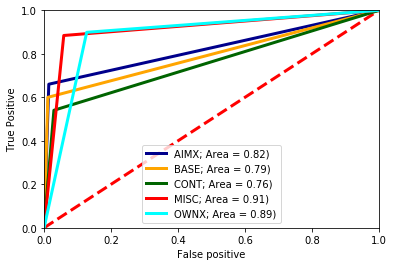

In [10]:
plot_ROC(numpy.unique(TrainDF['label']), test_lbl, prediction)

* **Confusion матрица:**

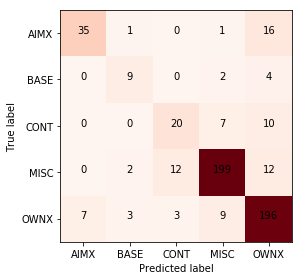

In [11]:
plotConfMatrix(test_lbl, prediction, numpy.unique(TrainDF['label']))

* **Точность классификации:**

In [12]:
round(metrics.accuracy_score(test_lbl, prediction), 2)

0.84

* **Сравнение с случайным выбором (**_Cohen's Kappa_**):**

In [13]:
round(metrics.cohen_kappa_score(test_lbl, prediction), 2)

0.75